In [98]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import recordreader
K = np.load("../../tools/camcal/cl20200307/camera_matrix.npy")
dist = np.load("../../tools/camcal/cl20200307/dist_coeffs.npy")
K[:2] /= 4.05
fx, fy = np.diag(K)[:2]
cx, cy = K[:2, 2]
K

array([[185.30157196,   0.        , 342.14900091],
       [  0.        , 185.57011132, 245.59128051],
       [  0.        ,   0.        ,   1.        ]])

In [101]:
import frontend

pts, origpts = frontend.genlut()
print(pts.shape)
centerlimit = 4
#ceillimit = 2
ceillimit = 8
ceilmask = (pts[2] > 0) & (np.sum(pts[:2]**2, axis=0) / pts[2]**2 < ceillimit**2) & (np.sum(origpts**2, axis=2) < centerlimit**2)
pts = pts[:2, ceilmask] / pts[2, ceilmask]
ceilmask.shape, pts.shape

cl2020307
(3, 480, 640)


((480, 640), (2, 181385))

(480, 640)

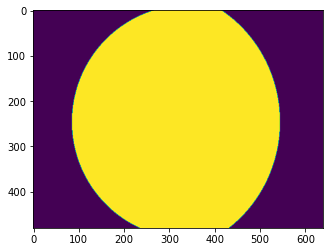

In [102]:
plt.imshow(ceilmask)
ceilmask.shape

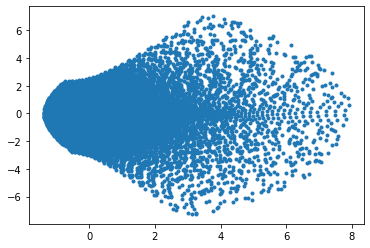

In [103]:
plt.plot(pts[0, ::10].T, pts[1, ::10].T, '.')

read header:  (1400, 1200, 1600, 15, 22, 0, 0, 0, 160, 20, 6, 200, 8, 100, 80, 100, -150, 18, 50, 0, -74, 100)


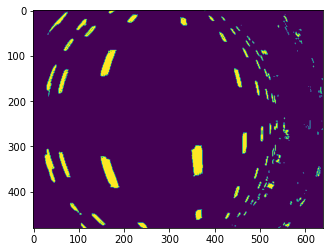

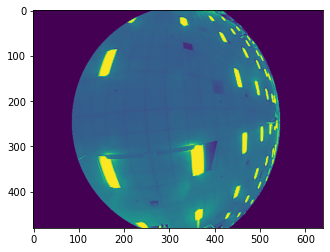

In [104]:
f = open("/opt/data/cycloid/cl20200307/cycloid-20200306-232852.rec", "rb")
_, hdr = recordreader.read_header(f)
for i in range(1):
    ok, frame = recordreader.read_frame(f)
gray = frame['yuv420'][:480]
f.close()

plt.imshow(gray > 240)
plt.show()
plt.imshow(gray * ceilmask)

(-6.199999999999999,
 20.199999999999996,
 -16.623883525430006,
 19.101554034030162)

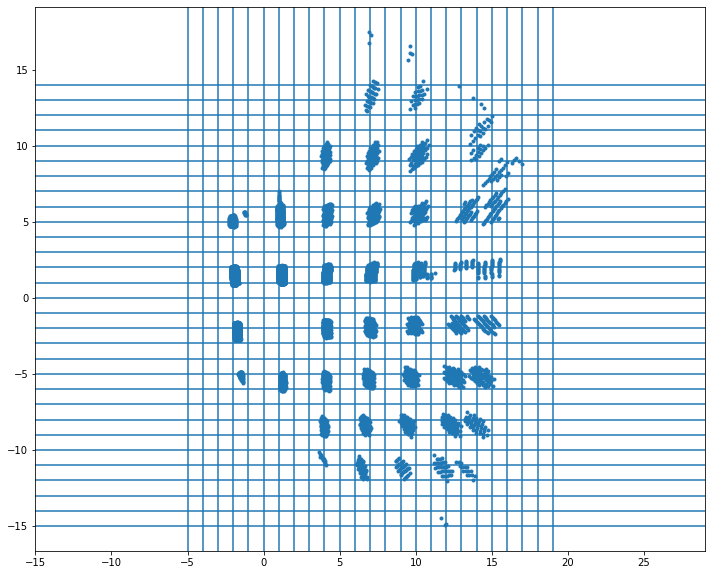

In [107]:
def remap(xi, yi, theta, Z, ceilpx):
    S, C = np.sin(theta), np.cos(theta)
    R = np.array([[C, S], [-S, C]])*Z
    p = np.dot(pts[:, ceilpx[ceilmask]].T, R.T) + np.array([xi, yi])
    return p

plt.figure(figsize=(12,10))
#xy = remap(0.7, -2, 1.2, 4, gray > 220)
#xy = remap(0.8, 1.8, 1.19, 4, gray > 220)
#xy = remap(0, 0, 2.7284349649214974, 4, gray > 220)
xy = remap(0, 0, -.1, 2.4, gray > 220)

plt.plot(*xy.T, '.')
for i in range(-5, 20):
    plt.axvline(i)
for j in range(-15, 15):
    plt.axhline(j)
plt.axis('equal')

In [8]:
n, msk = cv2.connectedComponents((ceilmask*gray > 220).astype(np.uint8))
np.argmax(np.histogram(msk, n)[0][1:])

21

In [9]:
np.linalg.svd(np.cov(remap(0, 0, 0, 4, msk == 10).T))

/home/andy/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice
  """Entry point for launching an IPython kernel.
/home/andy/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/andy/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(array([[nan, nan],
        [nan, nan]]),
 array([nan, nan]),
 array([[nan, nan],
        [nan, nan]]))

In [10]:
np.arctan2(0.4015, -0.91585)

2.7284349649214974

(-1.5345795377456546,
 3.193982776154523,
 -2.8866494673189727,
 2.788533326864594)

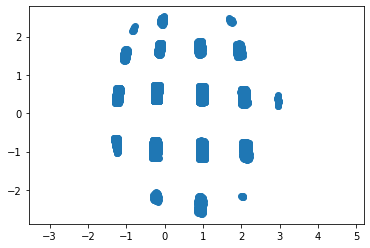

In [84]:
plt.scatter(*(pts[:, msk[ceilmask] != 0]))
plt.axis('equal')

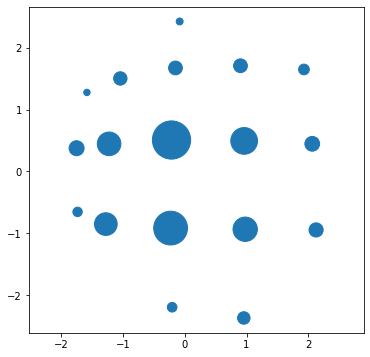

In [12]:
import ba

def features(greyimg, thr=230, minpix=20):
    # get ceiling light features from fisheye image
    n, msk = cv2.connectedComponents((ba.ceilmask*greyimg > thr).astype(np.uint8))
    F = []
    N = []
    C = []
    for i in range(n):
        P = pts[:, msk[ceilmask] == i+1].T
        if P.shape[0] < minpix:
            continue
        N.append(P.shape[0])
        M = np.mean(P, axis=0)
        C.append(np.linalg.svd(np.cov((P - M).T))[0][:, 0])
        F.append(M)
    
    return np.array(F), np.array(N), np.array(C)

F, N, C = features(gray, 240)
plt.figure(figsize=(6,6))
plt.axis('equal')
orient = np.dot(N, C)
S, C = orient / np.linalg.norm(orient)
R = np.array([[C, -S], [S, C]])
plt.scatter(*np.dot(R, F.T), N)


In [13]:
lmframe = []

f = open("/opt/data/cycloid/cl20200307/cycloid-20200306-194141.rec", "rb")
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    F, N, C = features(gray, 239, 5)
    S, C = orient / np.linalg.norm(orient)
    #R = np.array([[C, -S], [S, C]])
    #x, y = np.dot(R, F.T)
    x, y = F.T
    img = np.zeros((480, 640, 3), np.uint8)
    l = []
    for i in range(len(x)):
        if N[i] > 250 and x[i]**2 < 4 and y[i]**2 < 4:
            c = (170, 255, 170)
            l.append([x[i], y[i], N[i]])
        else:
            c = (170, 170, 170)
        cv2.circle(img, (int(16*320 + x[i] * 800), int(16*240 + y[i] * 800)), int(8*np.sqrt(N[i])), c, shift=4)
    lmframe.append(l)
    cv2.imshow("map", img)
    #cv2.imshow("gray", gray)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

f.close()
cv2.destroyAllWindows()
cv2.waitKey(1)

read header:  (300, 700, 1800, 12, 18, 9, 0, 0, 20, 50, 8, 60, 60, 100, -150, 7, 10, 1000, -74, 100)


-1

(-1.7867402490863906,
 0.5840371962793621,
 -1.8395869463304522,
 0.9781501003201888)

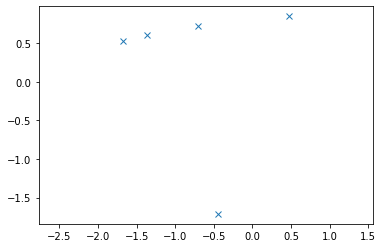

In [14]:
L = np.array(lmframe[0])
X = np.array([0., 0, 0])
plt.plot(L[:, 0], L[:, 1], 'x')
plt.axis('equal')

In [15]:
# cost_jk: min_i rho(R_j*L_k + X_j - L_i)
def cost(x, y, L):  # state, measurement, landmarks
    theta = x[2]
    S, C = np.sin(theta), np.cos(theta)
    R = np.array([[C, -S], [S, C]])
    #dR = np.array([[-S, -C], [C, -S]])
    # translate all landmarks into camera frame
    Lx = np.dot(R, (L[:, :2] - x[:2]).T)
    g = np.zeros(3)
    c = 0
    yi = np.zeros(len(y), np.int)
    for k, Lk in enumerate(y):
        DL = (Lk[:2] - Lx.T)
        cost = np.sum(DL**2, axis=1)
        i = np.argmin(cost)
        if cost[i] > 1:
            # add a new landmark
            Lkw = np.dot(R.T, Lk[:2]) + x[:2]
            yi[k] = L.shape[0]
            L = np.vstack([L, Lkw])
            continue
        yi[k] = i
        Lix, Liy = L[i, :2]
        Lkx, Lky = Lk[:2]
        x0 = S
        x1 = Lix - x[0]
        x2 = x0*x1
        x3 = C
        x4 = Liy - x[1]
        x5 = -Lky + x2 + x3*x4
        x6 = x1*x3
        x7 = x0*x4
        x8 = -Lkx + x6 - x7
        x9 = 2*x0
        x10 = 2*x3
        
        dx = -x10*x8 - x5*x9
        dy = -x10*x5 + x8*x9
        dtheta = x5*2*(x6 - x7) - x8*(x10*x4 + 2*x2)
        g += [Lk[2]*dx, Lk[2]*dy, Lk[2]*dtheta]
        c += cost[i]
    return c, g/1000., yi, L

cost([0.0, 0, 0], lmframe[20], np.array(lmframe[0])[:, :2])[:2]

(0.7585621853657137, array([-1.10648766, -0.15168176, -1.9896984 ]))

In [16]:
# first pass, initial positions for landmarks and state
L = np.array(lmframe[0])[:, :2]
x = np.array([0., 0., 0.])
xs = []
xs.append(x.copy())
Lis = [np.arange(len(L))]
for j in range(1, len(lmframe)):
    for i in range(20):
        c, g, Li, L = cost(x, lmframe[j], L)
        x -= 0.02*g
    xs.append(x.copy())
    Lis.append(Li)


In [17]:
xs = np.array(xs)
xs.shape

(99, 3)

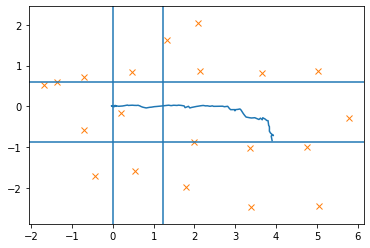

In [18]:
plt.plot(xs[:, 0], xs[:, 1])
plt.plot(L[:, 0], L[:, 1], 'x')
plt.axis('equal')
plt.axvline(0)
plt.axvline(1.237)
plt.axhline(0.6)
plt.axhline(0.6 - 1.48)

In [19]:
from scipy.sparse import lil_matrix

Nl = L.shape[0]
Nx = xs.shape[0]

# now we have all our assignments, we can run a dense bundle adjustment step pretty easily
def totalcost(X):
    L = X[:2*Nl].reshape((-1, 2))
    xs = X[2*Nl:].reshape((-1, 3))
    cost = []
    for i in range(0, len(xs)):
        f = np.array(lmframe[i])
        x = xs[i]
        theta = x[2]
        S, C = np.sin(theta), np.cos(theta)
        R = np.array([[C, -S], [S, C]])
        Lx = np.dot(R, (L[:, :2] - x[:2]).T)
        d = f[:, :2] - Lx[:, Lis[i]].T
        cost.extend((d.T * np.sqrt(f[:, 2])).reshape(-1))
    return np.float32(cost)

def totalsparsity():
    n = 2*Nl + 3*Nx
    m = 0
    for i in range(0, len(xs)):
        m += 2*len(Lis[i])
    s = lil_matrix((m, n), dtype=int)
    mi = 0
    for i in range(0, len(xs)):
        for j in range(len(Lis[i])):
            Lij = Lis[i][j]
            s[mi:mi+2, Lij*2:Lij*2+2] = 1
            s[mi:mi+2, 2*Nl + 3*i:2*Nl + 3*i+3] = 1
            mi += 2
    return s    

X = np.concatenate([L.reshape(-1), xs.reshape(-1)])
X.shape, totalcost(X).shape

((337,), (1346,))

In [20]:
totalsparsity()

<1346x337 sparse matrix of type '<class 'numpy.int64'>'
	with 6730 stored elements in List of Lists format>

In [21]:
import scipy.optimize

res = scipy.optimize.least_squares(totalcost, X, jac_sparsity=totalsparsity(), tr_solver='lsmr', loss='linear', verbose=2, )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4288e+04                                    1.55e+04    
       1              2         2.3753e+04      5.36e+02       1.70e+00       1.14e+04    
       2             14         2.3753e+04      0.00e+00       0.00e+00       1.14e+04    
`xtol` termination condition is satisfied.
Function evaluations 14, initial cost 2.4288e+04, final cost 2.3753e+04, first-order optimality 1.14e+04.


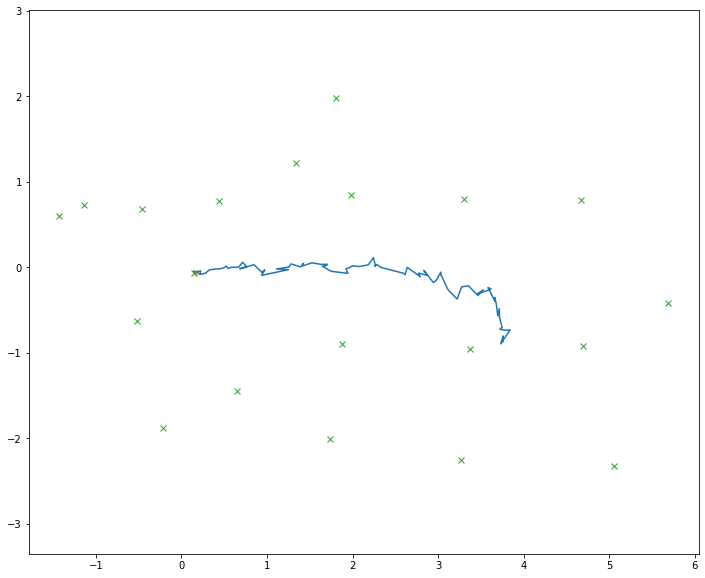

In [22]:
def showresult(X):
    plt.axis('equal')
    L = X[:2*Nl].reshape((-1, 2))
    xs = X[2*Nl:].reshape((-1, 3))
    plt.plot(xs[:, 0], xs[:, 1])
    plt.plot(xs[0, 0], xs[0, 1], '+')
    plt.plot(L[:, 0], L[:, 1], 'x')

plt.figure(figsize=(12,10))
showresult(res['x'])
#plt.plot(xs[:, 0], xs[:, 1])
#plt.plot(L[:, 0], L[:, 1], 'x')

In [23]:
f = open("/opt/data/cycloid/cl20200307/cycloid-20200306-232852.rec", "rb")
i = 0
acts = []
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    act = frame['activations']
    acts.append(act[1:] - act[:-1])
f.close()
len(acts), len(xs)

read header:  (1400, 1200, 1600, 15, 22, 0, 0, 0, 160, 20, 6, 200, 8, 100, 80, 100, -150, 18, 50, 0, -74, 100)


KeyError: 'activations'

In [24]:
r = len(xs)
nxs = res['x'][2*Nl:].reshape((-1, 3))
angs = -np.pi/2 + 2*np.pi * np.argmax(acts[:r], axis=1) / len(acts[0])
plt.figure(figsize=(12,10))
plt.plot(nxs[:r, 0], nxs[:r, 1])
for i in range(r):
    plt.plot([nxs[i, 0], nxs[i, 0] + np.cos(angs[i] - nxs[i, 2])],
            [nxs[i, 1], nxs[i, 1] + np.sin(angs[i] - nxs[i, 2])])
#plt.plot(xs[:r, 0] + np.cos(angs), xs[:r, 1] + np.sin(angs), '.')
plt.axis('equal')
showresult(res['x'])


AxisError: axis 1 is out of bounds for array of dimension 1

In [25]:
np.argmax(acts[0]) / len(acts[0])

IndexError: list index out of range

In [26]:
plt.plot(-angs)

NameError: name 'angs' is not defined

In [27]:
import frontend

ptest = frontend.genlut()
ptest.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [28]:
plt.imshow((ptest[2] > 0) & (np.sum(ptest[:2]**2, axis=0) / ptest[2]**2 < 2.3**2))

IndexError: tuple index out of range

In [29]:
plt.imshow((ptest[2] < 0))

IndexError: tuple index out of range

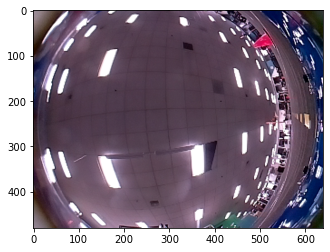

In [30]:
bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
plt.imshow(bgr[:, :, ::-1])

In [31]:
def preview(Knew, R):
    f = open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb")

    for frame in recordreader.RecordIterator(f):
        bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
        frontview = cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))
        cv2.imshow("frontview", frontview)
        k = cv2.waitKey(1)
        if k == ord('q'):
            break
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    f.close()


def writevid(Knew, R):
    vidout = cv2.VideoWriter("frontview.mp4", cv2.VideoWriter_fourcc('X', '2', '6', '4'), 30, (640, 360), True)
    f = open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb")

    for frame in recordreader.RecordIterator(f):
        bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
        frontview = cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))
        vidout.write(frontview)
    del vidout
    f.close()


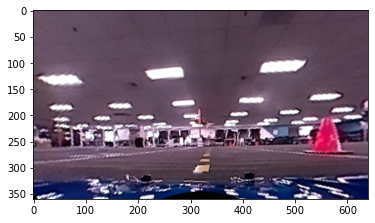

In [32]:
Knew = np.array([
    [-250, 0, 320],
    [0, 250, 260],
    [0, 0, 1]
])
R=cv2.Rodrigues(np.array([0, (22.-90)*np.pi/180., 0]))[0]
R = np.dot(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]), R)
plt.imshow(cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))[:, :, ::-1])

In [33]:
preview(Knew, R)

FileNotFoundError: [Errno 2] No such file or directory: '../../logs/cl20190707/cycloid-20190707-162426.rec'

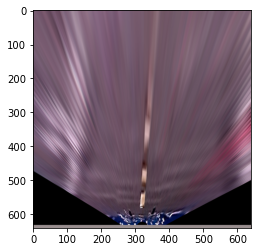

In [34]:
Knew = np.array([
    [-20, 0, 320],
    [0, 20, 680],
    [0, 0, 1]
])
R=cv2.Rodrigues(np.array([0, (22-180)*np.pi/180., 0]))[0]
R = np.dot(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]), R)
plt.imshow(cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 640))[:, :, ::-1])

In [35]:
vidout = cv2.VideoWriter("birdseye.mp4", cv2.VideoWriter_fourcc('X', '2', '6', '4'), 30, (640, 640), True)
f = open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb")
for frame in recordreader.RecordIterator(f):
    bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
    frontview = cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 640))
    #cv2.imshow("be", frontview)
    vidout.write(frontview)
    #k = cv2.waitKey(1)
    #if k == ord('q'):
    #    break
#cv2.destroyAllWindows()
#cv2.waitKey(1)
del vidout
f.close()


FileNotFoundError: [Errno 2] No such file or directory: '../../logs/cl20190707/cycloid-20190707-162426.rec'

In [36]:
Knew = np.array([
    [-250, 0, 320],
    [0, 250, 260],
    [0, 0, 1]
])
R=cv2.Rodrigues(np.array([0, (22.-90)*np.pi/180., 0]))[0]
R = np.dot(cv2.Rodrigues(np.array([70*np.pi/180., 0, 0]))[0], R)
R = np.dot(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]), R)
#plt.imshow(cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))[:, :, ::-1])

In [37]:
preview(Knew, R)

FileNotFoundError: [Errno 2] No such file or directory: '../../logs/cl20190707/cycloid-20190707-162426.rec'

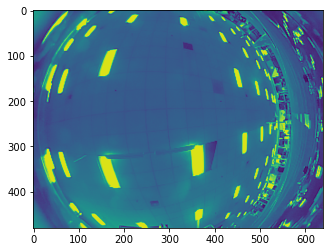

In [38]:
plt.imshow(gray)


so we should have a grid spacing of 10' in the x direction and 12' in the y direction, divided by 8'1"

(-0.617283950617284, 1.234567901234568)

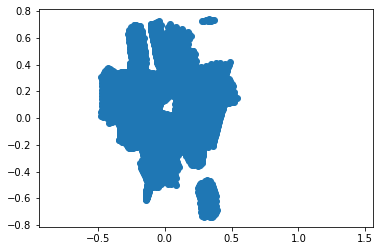

In [39]:
def Rmat(theta):
    S, C = np.sin(theta), np.cos(theta)
    return np.array([
        [C, S],
        [-S, C]
    ])

def RdRmat(theta):
    S, C = np.sin(theta), np.cos(theta)
    return np.array([
        [C, S],
        [-S, C]
    ]), np.array([
        [-S, C],
        [-C, -S]
    ])

xspc = 10/8.1
yspc = 12/8.1
xypts = pts[:, (gray[ceilmask] > 240)]
xypts = np.dot(Rmat(0.0), xypts)
xydist = ((xypts.T + [0.25 + xspc/2, 0.85 + yspc/2]) % [xspc, yspc]) - [xspc/2, yspc/2]
plt.scatter(*xydist.T)
plt.axis('equal')
plt.xlim(-xspc/2, xspc)
#plt.ylim(-yspc/2, yspc)

(480.0, 0.0)

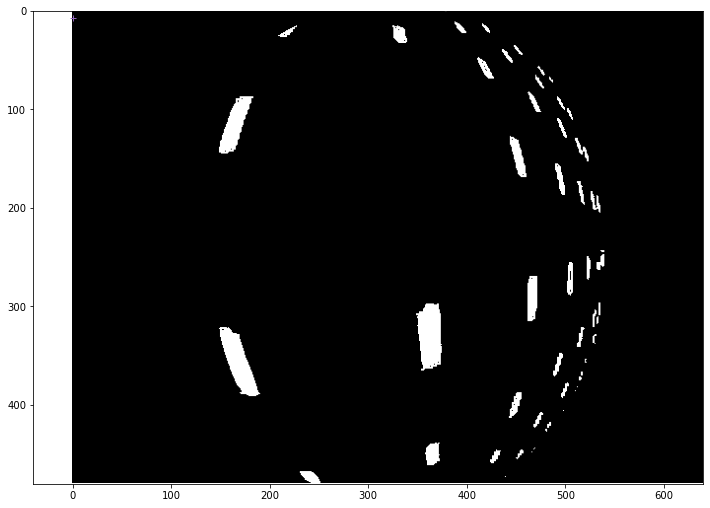

In [205]:
def mkgrid(xspc, yspc, N, u, v, theta):
    mg = (np.mgrid[:N, :N].reshape(2, -1).T - [(N-1)/2, (N-1)/2]) * [xspc, yspc] - [u, v]
    mg = np.dot(Rmat(theta), mg.T)
    mg = np.vstack([mg, np.ones((1, mg.shape[1]))])
    mg = np.dot(cv2.Rodrigues(np.array([0, (-22.)*np.pi/180., 0]))[0], mg)
    #mg = mg[:, mg[2] > 0]
    mask = mg[2] > 0
    mg /= mg[2]
    return cv2.fisheye.distortPoints(mg.T[None, :, :2].astype(np.float32), K, dist), mask

def mkgrid2(xspc, yspc, N, u, v, theta):
    mg = (np.mgrid[:N, :N].reshape(2, -1).T - [(N-1)/2, (N-1)/2]) * [xspc, yspc] - [u, v]
    mg = np.dot(Rmat(theta), mg.T)
    mg = np.vstack([mg, np.ones((1, mg.shape[1]))])
    #mg = np.dot(cv2.Rodrigues(np.array([0, (-22.)*np.pi/180., 0]))[0], mg)
    #mg = mg[:, mg[2] > 0]
    #mask = mg[2] > 0
    #mg /= mg[2]
    #return cv2.fisheye.distortPoints(mg.T[None, :, :2].astype(np.float32), K, dist), mask
    return mg

plt.figure(figsize=(12, 10))
plt.imshow(gray*ceilmask > 240, cmap='gray')
#plt.imshow(bgr[:, :, ::-1])
plt.plot(*mkgrid2(xspc, yspc, 13, 0,  0, 0)[0].T, '+')
#plt.plot(*mkgrid(xspc, yspc, 13, -0.47177957,  -0.65886156, 0.07611015)[0].T, '+')
plt.ylim(480, 0)

[0. 0. 0.] 1944.8906124541109 [0.29134623 0.2430157  0.02456614]
[0.29134623 0.2430157  0.02456614] 824.5364965225059 [ 0.16601093  0.3720387  -0.06705799]
[ 0.45735716  0.6150544  -0.04249186] 202.48504980852962 [ 0.02025756  0.03902568 -0.0256718 ]
[ 0.47761472  0.65408009 -0.06816365] 180.84008837098162 [-0.00422014  0.00367057 -0.00633283]
[ 0.47339458  0.65775066 -0.07449648] 179.6626585773975 [-0.00142457  0.00098243 -0.00149452]
[ 0.47197001  0.65873309 -0.07599101]
(6, 169, 2) int64
<class 'numpy.float64'>


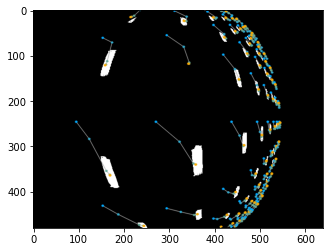

In [258]:
#xy0, mask0 = mkgrid(xspc, yspc, 13, -0.29134623, -0.2430157,  -0.02456614)
b = np.zeros(3)

xy = match(gray)
xy0, mask = mkgrid(xspc, yspc, 13, 0, 0, 0)
xy0 = (xy0[0]*16).astype(np.int)
grids = [xy0]
for i in range(5):
    c, dB = cost(xy, *b)
    print(b, c, dB)
    b += dB
    xy1, mask1 = mkgrid(xspc, yspc, 13, -b[0], -b[1], -b[2])
    grids.append((xy1[0]*16).astype(np.int))
    mask = mask & mask1
print(b)
grids = np.array(grids)
print(grids.shape, grids.dtype)

img = np.repeat(255*(gray*ceilmask > 240).astype(np.uint8)[:, :, None], 3, 2)
color = np.array([np.linspace(255, 0, 6), np.linspace(170, 170, 6), np.linspace(0, 255, 6)]).T
print(type(tuple(color[0])[0]))
for j in range(len(xy0)):
    if not mask[j]:
        continue
    for i in range(5):
        cv2.line(img, (grids[i, j, 0], grids[i, j, 1]), (grids[i+1, j, 0], grids[i+1, j, 1]), (170, 170, 170), 1, cv2.LINE_AA, 4)
    for i in range(6):
        cv2.circle(img, (grids[i, j, 0], grids[i, j, 1]), 16*1, tuple(color[i]), 2, cv2.LINE_AA, 4)
        #cv2.circle(img, (xy1[i, 0], xy1[i, 1]), 16*2, (0, 170, 255), 2, cv2.LINE_AA, 4)

plt.imshow(img[:, :, ::-1])
#cv2.imwrite("ceiltrack-align.png", img)
img_fisheye = img

[0. 0. 0.] 1944.8906124541109 [0.29134623 0.2430157  0.02456614]
[0.29134623 0.2430157  0.02456614] 824.5364965225059 [ 0.16601093  0.3720387  -0.06705799]
[ 0.45735716  0.6150544  -0.04249186] 202.48504980852962 [ 0.02025756  0.03902568 -0.0256718 ]
[ 0.47761472  0.65408009 -0.06816365] 180.84008837098162 [-0.00422014  0.00367057 -0.00633283]
[ 0.47339458  0.65775066 -0.07449648] 179.6626585773975 [-0.00142457  0.00098243 -0.00149452]
[ 0.47197001  0.65873309 -0.07599101]
(6, 169, 3) int64


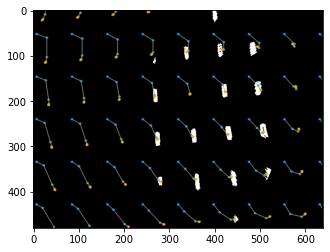

In [259]:
#xy0, mask0 = mkgrid(xspc, yspc, 13, -0.29134623, -0.2430157,  -0.02456614)
b = np.zeros(3)

KK = np.float32([[62.5, 0, 320], [0, 62.5, 240], [0, 0, 1]])
xy = match(gray)
xy0 = mkgrid2(xspc, yspc, 13, 0, 0, 0)
xy0 = KK@xy0
#xy0 /= xy0[2]
xy0 = (xy0*16).astype(np.int)
grids = [xy0.T]
for i in range(5):
    c, dB = cost(xy, *b)
    print(b, c, dB)
    b += dB
    xy1 = mkgrid2(xspc, yspc, 13, -b[0], -b[1], -b[2])
    xy1 = KK@xy1
    #xy1 /= xy1[2]
    xy1 = (xy1*16).astype(np.int)
    grids.append(xy1.T)
print(b)
grids = np.array(grids)
print(grids.shape, grids.dtype)
R=cv2.Rodrigues(np.array([0, (22.)*np.pi/180., 0]))[0]

uplights = cv2.fisheye.undistortImage(gray*ceilmask[:, :], K=K, D=dist, Knew=KK@R, new_size=(640, 480))
img = np.repeat(255*(uplights*ceilmask > 240).astype(np.uint8)[:, :, None], 3, 2)
color = np.array([np.linspace(255, 0, 6), np.linspace(170, 170, 6), np.linspace(0, 255, 6)]).T
for j in range(len(xy0.T)):
    for i in range(5):
        cv2.line(img, (grids[i, j, 0], grids[i, j, 1]), (grids[i+1, j, 0], grids[i+1, j, 1]), (170, 170, 170), 1, cv2.LINE_AA, 4)
    for i in range(6):
        cv2.circle(img, (grids[i, j, 0], grids[i, j, 1]), 16*1, tuple(color[i]), 2, cv2.LINE_AA, 4)
        #cv2.circle(img, (xy1[i, 0], xy1[i, 1]), 16*2, (0, 170, 255), 2, cv2.LINE_AA, 4)

plt.imshow(img[:, :, ::-1])
#cv2.imwrite("ceiltrack-align.png", img)
img_flat = img

True

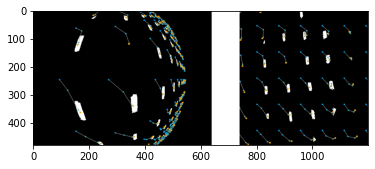

In [262]:
combined = 255*np.ones((480, 640+640-180+100, 3), np.uint8)
combined[:, :640] = img_fisheye
combined[:, -460:] = img_flat[:, 180:]
#cv2.line(combined, (660, 240), (720, 240), (0, 0, 0), 5, cv2.LINE_AA)
#cv2.line(combined, (700, 220), (720, 240), (0, 0, 0), 5, cv2.LINE_AA)
#cv2.line(combined, (700, 260), (720, 240), (0, 0, 0), 5, cv2.LINE_AA)
plt.imshow(combined[:, :, ::-1])
cv2.imwrite("ceiltrack-iteration.png", combined)


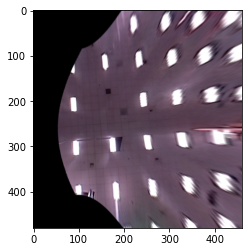

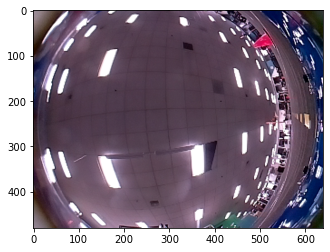

In [243]:
R=cv2.Rodrigues(np.array([0, (22.)*np.pi/180., 0]))[0]
R = np.float32([[-.25,0,0],[0,.25,0],[0,0,1]]) @ R
upbgr = cv2.fisheye.undistortImage(bgr*ceilmask[:, :, None], K=K, D=dist, Knew=Knew@R, new_size=(640, 480))
plt.imshow(upbgr[:, 180:, ::-1])
plt.show()
plt.imshow(bgr[:, :, ::-1])

In [110]:
combined = 255*np.ones((480, 640+640-180+100, 3), np.uint8)
combined[:, :640] = bgr
combined[:, -460:] = upbgr[:, 180:]
cv2.line(combined, (660, 240), (720, 240), (0, 0, 0), 5)
cv2.line(combined, (700, 220), (720, 240), (0, 0, 0), 5)
cv2.line(combined, (700, 260), (720, 240), (0, 0, 0), 5)
cv2.imwrite("ceiltrack-undistort.jpg", combined)
#cv2.imwrite("ceilslam-fisheye.jpg", bgr)
#cv2.imwrite("ceilslam-upview.jpg", upbgr[:, 180:])
#plt.imshow(combined)

True

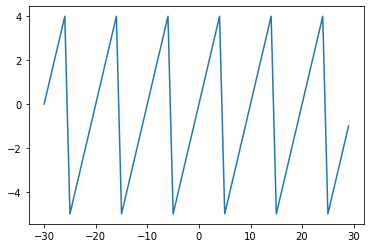

In [111]:
def moddist(x, q):
    return (x+q/2)%q - q/2

plt.plot(np.arange(-30, 30), moddist(np.arange(-30, 30), 10))

In [112]:
# pixel cost:
# Rxy R.xy
# cost = 1/2 [moddist(Rx - u, xspc)**2,  moddist(Ry - v, yspc)**2]
# dcost/duv = [-(Rx - u),    0   ]
#             [    0,    -(Ry, v)]
# dcost/dtheta = [(Rx - u)*d(Rx)/dtheta, (Ry - v)*d(Ry)/dtheta]

def moddist(x, q):
    return (x+q/2)%q - q/2

def match(gray):
    return pts[:, gray[ceilmask] > 240]

def cost(xy, u, v, theta):
    N = xy.shape[1]
    x = xy[0]
    y = xy[1]
    S = np.sin(theta)
    C = np.cos(theta)
    dRx = x*S - C*y
    dRy = x*C + S*y
    dx = moddist(x*C + y*S - u, xspc)
    dy = moddist(-x*S + y*C - v, yspc)
    S2 = np.sum(dRx)
    S3 = np.sum(dRy)
    JTJ = np.array([[N, 0, S2], [0, N, S3], [S2, S3, np.sum(x**2 + y**2)]])
    JTr = np.array([-np.sum(dx), -np.sum(dy), -np.sum(dx*dRx + dy*dRy)])
    return 0.5*np.sum(dx**2 + dy**2), -np.linalg.solve(JTJ + np.eye(3), JTr)

xy = match(gray)
print(cost(xy, -.248, .145, 0.0126))
%timeit cost(xy, -.248, .145, 0.0126)

(1469.6761270100415, array([-0.24723226,  0.34709785,  0.00309867]))
286 µs ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [113]:
#e = 1e-6
#s, *_ = cost(gray, -2.25, 0.7, 0.03)
#s1, *_ = cost(gray, -2.25+e, 0.7, 0.03)
#s2, *_ = cost(gray, -2.25, 0.7+e, 0.03)
#s3, *_ = cost(gray, -2.25, 0.7, 0.03+e)
#print(np.sum(s))
#print(np.sum(Ju, axis=1) + np.sum(Jv, axis=1))
#print(np.sum(s1-s)/e, np.sum(s2-s)/e, np.sum(s3-s)/e)

In [114]:
# 8.0 159701.53572861606
# 8.1 150074.75218936958
# 8.2 143326.9812395357
# 8.3 139387.52407613743
# 8.4 138146.47735365925
# 8.5 139404.41798315747
ceilheight = 8.0
xspc = 10/ceilheight
#xspc = 2/ceilheight
yspc = 12/ceilheight

b = np.zeros(3)

xy = match(gray)
for i in range(10):
    c, dB = cost(xy, *b)
    print(b, c, dB)
    b += dB
print(b)

[0. 0. 0.] 1944.8906124541109 [0.29134623 0.2430157  0.02456614]
[0.29134623 0.2430157  0.02456614] 824.5364965225059 [ 0.16601093  0.3720387  -0.06705799]
[ 0.45735716  0.6150544  -0.04249186] 202.48504980852962 [ 0.02025756  0.03902568 -0.0256718 ]
[ 0.47761472  0.65408009 -0.06816365] 180.84008837098162 [-0.00422014  0.00367057 -0.00633283]
[ 0.47339458  0.65775066 -0.07449648] 179.6626585773975 [-0.00142457  0.00098243 -0.00149452]
[ 0.47197001  0.65873309 -0.07599101] 179.592840373981 [-0.00019056  0.00012981 -0.0001204 ]
[ 0.47177945  0.6588629  -0.07611141] 179.59239251856695 [ 0.00000012 -0.00000135  0.00000127]
[ 0.47177957  0.65886155 -0.07611014] 179.59239248108912 [-0.          0.00000001 -0.00000001]
[ 0.47177957  0.65886156 -0.07611015] 179.59239248108497 [ 0. -0.  0.]
[ 0.47177957  0.65886156 -0.07611015] 179.59239248108494 [-0.  0. -0.]
[ 0.47177957  0.65886156 -0.07611015]


In [36]:
f = open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb")
track = []
gyroz = []
b = np.zeros(3)
totalc = 0
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    gyroz.append(frame['carstate'][3][2])
    xy = match(gray)
    for i in range(6):
        c, dB = cost(xy, *b)
        b += dB
    track.append(b.copy())
    totalc += c
f.close()
print(totalc)

191870.63881092414


(-6.6875, 2.9375, -0.225, 4.725)

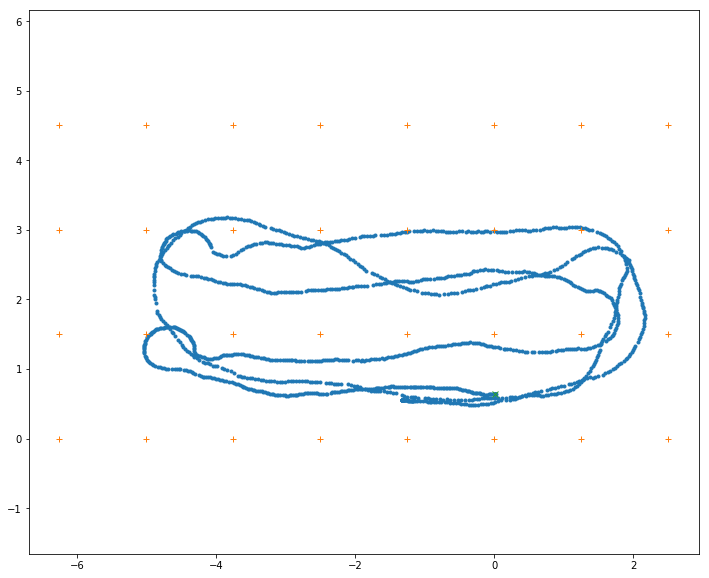

In [37]:
track = np.array(track)
plt.figure(figsize=(12,10))
plt.plot(*track[:, :2].T, '.')
mg = (np.mgrid[:8, :4].reshape(2, -1).T - [5, 0]) * [xspc, yspc]
plt.plot(mg[:, 0], mg[:, 1], '+')
plt.plot(*track[0, :2].T, 'x')
plt.axis('equal')

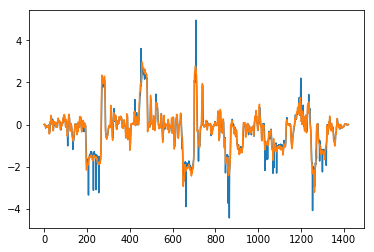

In [38]:
plt.plot(-30*(track[1:, 2] - track[:-1, 2]))
plt.plot(gyroz)

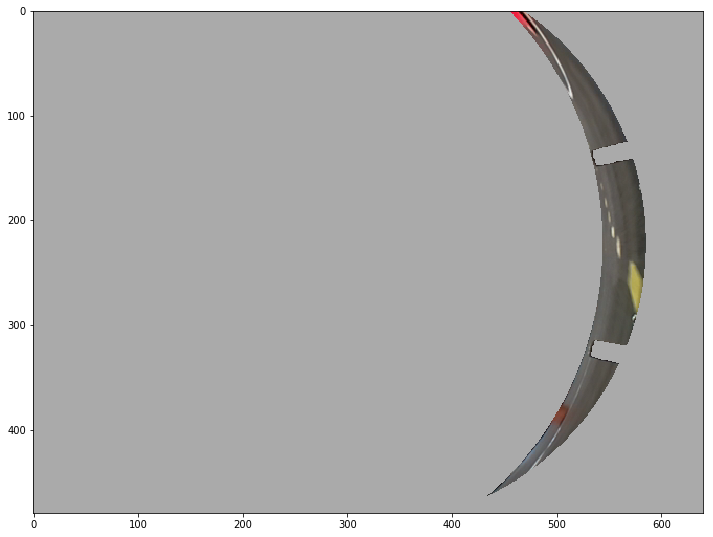

In [39]:
floorheight = 0.2 / ceilheight  # it stands 90mm off the ground, which is almost exactly 0.3 feet (4")
floorlut = frontend.genlut()[0]
fxy = floorlut[:2] / floorlut[2]
#floormask = (floorlut[2] < 0) & (np.sum(fxy**2, axis=0) < 128**2) & (np.sum(origpts**2, axis=2) < 6**2) & (gray > 50)
floormask = (floorlut[2] < 0) & (np.sum(fxy**2, axis=0) < 128**2) & (np.sum(origpts**2, axis=2) < 6**2) & (gray > 50)

plt.figure(figsize=(12,10))
plt.imshow(bgr[:, :, ::-1]*floormask[:, :, None] + 170*(1-floormask[:, :, None]))
fpts = floorheight * fxy[:, floormask]

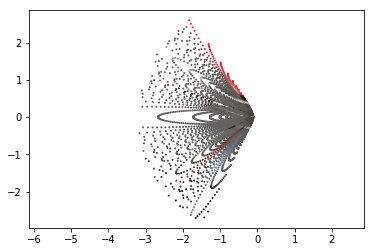

In [40]:
plt.axis('equal')
plt.scatter(*np.dot(Rmat(0.), fpts), s=1, c=bgr[floormask, ::-1]/255.0)

In [1]:
vidout = cv2.VideoWriter("mapping.mp4", cv2.VideoWriter_fourcc('X', '2', '6', '4'), 30, (640, 360), True)

ceilheight = 8.25
xspc = 10/ceilheight
yspc = 12/ceilheight
#xspc = 2/ceilheight
#yspc = 12/ceilheight
floorheight = 0.23 / ceilheight  # it stands 90mm off the ground, which is almost exactly 0.3 feet (4")

floorlut, origpts = frontend.genlut()
fxy = floorlut[:2] / floorlut[2]
floormask = (floorlut[2] < 0) & (np.sum(fxy**2, axis=0) < 16**2) & (np.sum(origpts**2, axis=2) < 6**2) & (gray > 50)
fpts = floorheight * fxy[:, floormask]

f = open("../../logs/cl20190707/cycloid-20190707-183147.rec", "rb")
#f = open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb")
track = []
totalc = 0
mapsz = 360
floormapbgr = np.zeros((mapsz, mapsz, 3))
floormapN = np.ones((mapsz, mapsz))
Z = 40
b = np.float32([230/Z, 40/Z, 0])
cmapsz = 50
ceilmapY = np.zeros((cmapsz, cmapsz))
ceilmapN = np.ones((cmapsz, cmapsz))
track = []
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
    gyroz.append(frame['carstate'][3][2])

    # use wheel odometry for correction
    # b[2] -= frame['carstate'][3][2] / 30.0

    xy = match(gray)
    for i in range(6):
        c, dB = cost(xy, *b)
        b += dB
    track.append(b.copy())
    totalc += c
    
    p = Z*(np.dot(Rmat(b[2]), fpts).T + b[:2])
    mask2 = (p[:, 0] >= 0) & (p[:, 1] >= 0) & (p[:, 0] < mapsz-1) & (p[:, 1] < mapsz-1)
    p = p[mask2]
    pi = p.astype(np.int)
    idxs = pi[:, 1] * mapsz + pi[:, 0]
    
    floormapN[:] += np.bincount(idxs, np.ones(len(idxs)), mapsz*mapsz).reshape((-1, mapsz))
    for i in range(3):
        floormapbgr[:, :, i] += np.bincount(idxs, bgr[floormask, i][mask2], mapsz*mapsz).reshape((-1, mapsz))
    #floormapbgr[pi[:, 1], pi[:, 0], :] = bgr[floormask][mask2]
    fview = (floormapbgr / floormapN[:, :, None]).astype(np.uint8)
    cv2.line(fview,
             (int(Z*b[0]), int(Z*b[1])),
             (int(Z*b[0] - 20*np.cos(b[2])), int(Z*b[1] + 20*np.sin(b[2]))),
             (0, 255, 0),
             1)
    
    p = (-np.dot(Rmat(b[2]), pts).T + b[:2])/xspc
    p[:, 0] += 8.5
    p[:, 1] += 20
    ceilp = p
    mask2 = (p[:, 0] >= 0) & (p[:, 1] >= 0) & (p[:, 0] < cmapsz-1) & (p[:, 1] < cmapsz-1)
    p = p[mask2]
    pi = p.astype(np.int)
    idxs = pi[:, 1] * cmapsz + pi[:, 0]
    
    ceilmapN[:] += np.bincount(idxs, np.ones(len(idxs)), cmapsz*cmapsz).reshape((-1, cmapsz))
    ceilmapY[:, :] += np.bincount(idxs, 255 * (gray[ceilmask][mask2] > 240), cmapsz*cmapsz).reshape((-1, cmapsz))
        
    Knew = np.array([
        [-250, 0, 320],
        [0, 250, 260],
        [0, 0, 1]
    ])
    R=cv2.Rodrigues(np.array([0, (22.-90)*np.pi/180., 0]))[0]
    R = np.dot(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]), R)

    for gp in mkgrid(xspc, yspc, 101, *-b)[0]:
        cv2.circle(bgr, (int(gp[0]), int(gp[1])), 3, (255, 0, 0), 1)
    bgr[~(ceilmask | floormask)] //= 3
    vframe = np.zeros((360, 640, 3), np.uint8)
    vframe[:, :480] = cv2.resize(bgr, (480, 360), cv2.INTER_LINEAR)
    # remaining area is 160x360
    vframe[:, 480:] = fview[:160, :, :].transpose((1, 0, 2))
    vidout.write(vframe)

    cv2.imshow("vframe", vframe)
    #cv2.imshow("ceilmap", cv2.resize(
    #    (ceilmapY / ceilmapN).astype(np.uint8), (cmapsz*16, cmapsz*16), interpolation=cv2.INTER_NEAREST))
    #cv2.imshow("front", cv2.fisheye.undistortImage(bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360)))
    #cv2.imshow("map", fview[::-1])
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    
f.close()
del vidout
print(totalc)
cv2.destroyAllWindows()
cv2.waitKey(1)
plt.imshow(floormapbgr / floormapN[:, :, None] / 255.0)


NameError: name 'cv2' is not defined

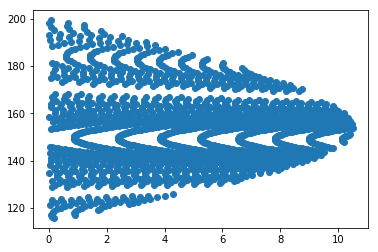

In [1098]:
plt.scatter(p[:, 0], p[:, 1])

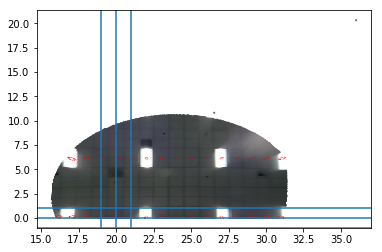

In [1207]:
p = ceilp
#p = (np.dot(Rmat(b[2]), pts).T - b[:2])/xspc
p.shape
plt.scatter(p[mask2, 0], p[mask2, 1], s=1, c=bgr[ceilmask, :][mask2]/255.0)
#plt.axis('equal')
for i in range(19, 22):
    plt.axvline(i)
for i in range(-1, 2):
    plt.axhline(i)


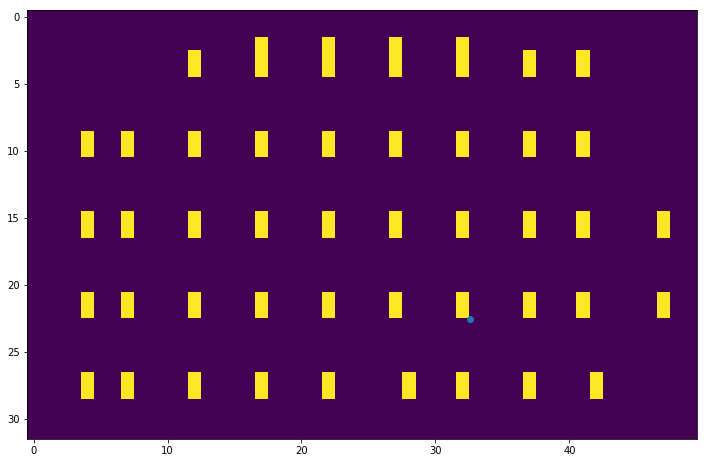

In [1318]:
plt.figure(figsize=(12,10))
plt.imshow((ceilmapY / np.sqrt(ceilmapN))[10:42] > 10000)
plt.plot(*(track[0]/xspc + [8.5, 20, 0])[:2], 'o')

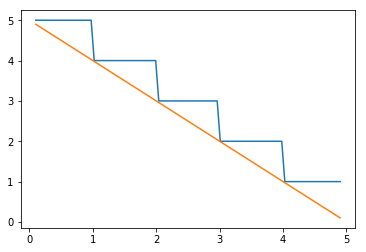

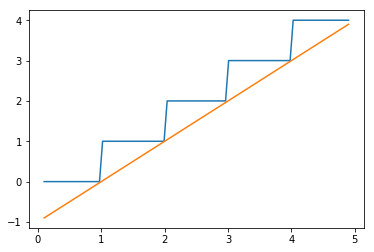

In [1349]:
# okay, this is the final light map we'll use from now on

lightmap = (((ceilmapY / np.sqrt(ceilmapN)) > 10000).astype(np.int)[10:42])

# now we need to generate a distance function to find the closest point on the grid
# run Dijkstra's algorithm on this to get minimum (x, y) distance (manhattan metric)
# then add the vector distance minus 1, so that:
# if the pixel is white and expected to be white, the distance is zero,
# but if it's white and not expected to be, it's the distance to the nearest white edge.
# we're doing squared x and y distances separately, so we precompute the x, y vector at each point on the map
# if the nearest is in the positive direction, use dist - fpart(u)
# if it's negative, use dist + fpart(u)-1

# ... or something like that?
u = np.linspace(0.1, 4.9, 100)
uf = u - u.astype(np.int)
dist = (5 - u).astype(np.int) + 1
plt.plot(u, dist)
plt.plot(u, dist - uf)
dist = (u).astype(np.int)
plt.show()
plt.plot(u, dist)
plt.plot(u, dist + uf - 1)

In [1439]:
# dijkstra's algorithm on lightmap
ldist = np.zeros((lightmap.shape[0], lightmap.shape[1], 2))
ldist[lightmap != 1] = 1000
while np.any(ldist == 1000):
#for i in range(100):
    cost = np.sum(np.abs(ldist)**2, axis=2)
    # now propagate cost in four directions:
    left = cost[:, 1:] < cost[:, :-1]
    ldist[:, :-1][left] = ldist[:, 1:][left] + [1, 0]
    
    right = cost[:, :-1] < cost[:, 1:]
    ldist[:, 1:][right] = ldist[:, :-1][right] + [-1, 0]
    
    up = cost[1:] < cost[:-1]
    ldist[:-1, :][up] = ldist[1:, :][up] + [0, 1]
    
    down = cost[:-1] < cost[1:]
    ldist[1:, :][down] = ldist[:-1, :][down] + [0, -1]

#plt.imshow(cost[:, :, 0] == cost[:, :, 0])

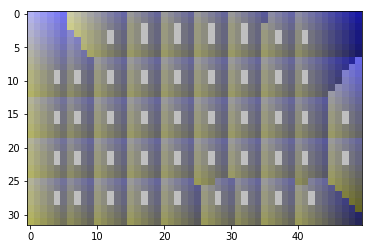

In [1440]:
plt.imshow(np.clip(ldist[:, :, [0, 0, 1]] + 5*(cost == 0)[:, :, None], -10, 10) / 20 + 0.5)

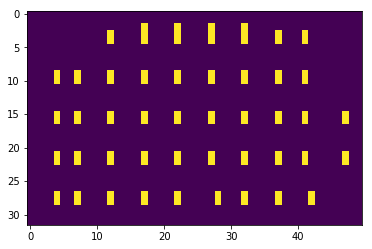

In [1434]:
plt.imshow(cost == 0)

In [ ]:
with open("../../logs/cl20190707/cycloid-20190707-162426.rec", "rb") as f:
    for frame in recordreader.RecordIterator(f):
        bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
        break

In [137]:
def undistortMap():
    CAM_TILT = np.array([0, 22. * np.pi / 180., 0])
    
    global K, dist
    K = np.load("../../tools/camcal/camera_matrix.npy")
    dist = np.load("../../tools/camcal/dist_coeffs.npy")
    K[:2] /= 4.05
    fx, fy = np.diag(K)[:2]
    cx, cy = K[:2, 2]
    uv = np.mgrid[:480, :640][[1, 0]].transpose(1, 2, 0).astype(np.float32)
    R = cv2.Rodrigues(CAM_TILT)[0]
    R = np.dot(cv2.Rodrigues(np.array([0.015, 0, 0]))[0], R)
    origpts = cv2.fisheye.undistortPoints(uv, K=K, D=dist)
    pts = np.stack([origpts[:, :, 0], origpts[:, :, 1], np.ones((480, 640))])
    return np.dot(R, pts.transpose(1, 0, 2)), origpts

pts, _ = undistortMap()

In [140]:
horizonang = np.tan(5*np.pi/180)
horizonmask = np.abs(pts[2]) <= horizonang
#plt.imshow(horizonmask[:, :, None]*bgr[:, :, ::-1])

Knew = np.array([
    [-250/3, 0, 320],
    [0, 250*5, 260],
    [0, 0, 1]
])
R=cv2.Rodrigues(np.array([0, (22.-90)*np.pi/180., 0]))[0]
R = np.dot(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]), R)
#plt.figure(figsize=(12, 6))
#plt.imshow(cv2.fisheye.undistortImage(horizonmask[:, :, None]*bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))[:, :, ::-1])

with open("/opt/data/cycloid/cl20200307/cycloid-20200306-232852.rec", "rb") as f:
    for frame in recordreader.RecordIterator(f):
        bgr = cv2.cvtColor(frame['yuv420'], cv2.COLOR_YUV2BGR_I420)
        im = cv2.fisheye.undistortImage(horizonmask[:, :, None]*bgr, K=K, D=dist, Knew=np.dot(Knew, R), new_size=(640, 360))
        #im = bgr * horizonmask[:, :, None]
        cv2.imshow("im", im)
        k = cv2.waitKey(1)
        if k == ord('q'):
            break
cv2.destroyAllWindows()
cv2.waitKey(1)

read header:  (1400, 1200, 1600, 15, 22, 0, 0, 0, 160, 20, 6, 200, 8, 100, 80, 100, -150, 18, 50, 0, -74, 100)


-1

array([[-6.03707421, -6.03693187, -6.03678953, ..., -5.94640265,
        -5.9462603 , -5.94611796],
       [-6.01189193, -6.01174959, -6.01160725, ..., -5.92122037,
        -5.92107803, -5.92093569],
       [-5.98671014, -5.98656779, -5.98642545, ..., -5.89603858,
        -5.89589623, -5.89575389],
       ...,
       [ 5.97472741,  5.97486976,  5.9750121 , ...,  6.06539897,
         6.06554132,  6.06568366],
       [ 5.99990969,  6.00005203,  6.00019437, ...,  6.09058125,
         6.09072359,  6.09086593],
       [ 6.02509149,  6.02523383,  6.02537617, ...,  6.11576305,
         6.11590539,  6.11604773]])

In [264]:
uv = np.mgrid[:480, :640][[1, 0]].transpose(1, 2, 0).astype(np.float32)
uv.shape

(480, 640, 2)